# Imports

In [187]:
import numpy as np
import pandas as pd
from collections import defaultdict
import pickle
from itertools import product
import time
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Model

In [220]:
class MonteCarloTreeSearchNode():
    # class wide lookup table (state:MCTS_Node)
    state_tbl = {}
    # class wide state sizes
    n_rows = 3
    n_cols = 3
    # class wide set to avoid double rewarding nodes in backprop
    marked = set([])

    def __init__(self,c_param=np.sqrt(2), win_reward_scalar=1, state = ((0,0,0),(0,0,0),(0,0,0)), parent=None, player = -1, reset_state_tbl=False):
        self.state = state
        if reset_state_tbl:
            type(self).state_tbl = {}
        # results[0] -> ties, results[1] -> wins, results[-1] -> losses
        self.results = [0,0,0]

        self.parents = [parent] if parent else []
        self.children = []
        self.player = player

        # Hyperparameters
        self.c_param = c_param
        self.win_reward_scalar = win_reward_scalar
        self.tie_reward_scalar = 1 - self.win_reward_scalar

        self.n_visits = 0

        self.is_game_over_node = self.get_winner_code() is not None
        self.unexplored_actions = self.get_legal_actions()

    def get_legal_actions(self, state=None):
        if not state:
            state = self.state
        return [(row, col) \
                for row, col in product(range(type(self).n_rows),range(type(self).n_cols)) \
                if state[row][col] == 0]

    def expand(self):
        # get an unexplored action
        action = self.unexplored_actions.pop(0)
        # apply that action to create the new state (make state list to mutate then tuple for tbl key)
        new_state = self.apply_action(action=action)

        if new_state in type(self).state_tbl:
            child = type(self).state_tbl[new_state]
            child.parents.append(self)
        else:
            child = MonteCarloTreeSearchNode(c_param=self.c_param, 
                                             win_reward_scalar = self.win_reward_scalar, 
                                             state=new_state, 
                                             parent=self, 
                                             player=-self.player)
            type(self).state_tbl[new_state] = child
        self.children.append(child)
        return type(self).state_tbl[new_state]

    def q(self):
        wins = self.results[1]
        ties = self.results[0]
        return self.win_reward_scalar * wins + self.tie_reward_scalar * ties

    def explore_exploit_val(self, parent):
        return (self.q() / self.n_visits) + self.c_param * np.sqrt( np.log(parent.n_visits)/self.n_visits )
    
    def explore_exploit_val_list(self, parent):
        return [child.explore_exploit_val(parent) for child in self.children]

    def expore_exploit(self):
        choices_weights = self.explore_exploit_val_list(parent=self)
        return self.children[np.argmax(choices_weights)]
    
    def best_child(self):
        child_visits = [child.n_visits for child in self.children]
        return self.children[np.argmax(child_visits)]

    def is_fully_expanded(self):
        return len(self.unexplored_actions) == 0
    
    def get_winner_code(self, state=None):
        if not state:
            state = self.state
        game_result = None
        # check rows
        for row in range(type(self).n_rows):
            if state[row][0] == state[row][1] == state[row][2] != 0: 
                game_result = state[row][0]

        # check cols
        for col in range(type(self).n_cols):
            if state[0][col] == state[1][col] == state[2][col] != 0: 
                game_result = state[row][0]
        
        # check diagonals
        if  (state[0][0] == state[1][1] == state[2][2] != 0) or \
            (state[0][2] == state[1][1] == state[2][0] != 0):
            game_result = state[1][1] 
        
        # check if board is full
        elif len(self.get_legal_actions(state)) == 0:
            game_result = 0
        # return None => game is not over
        return game_result
    
    def tree_policy(self):
        if self.is_game_over_node: return self
        if self.is_fully_expanded():
            child = self.expore_exploit()
            return child.tree_policy()
        return self.expand()

    def apply_action(self, action, state=None):
        if not state:
            state = self.state
        new_state = list(list([col for col in row]) for row in state)
        new_state[action[0]][action[1]] = -self.player
        new_state = tuple(tuple(col for col in row) for row in new_state)
        return new_state

    def random_rollout(self, state=None):
        if not state:
            state = self.state

        winner_code = self.get_winner_code(state)
        if winner_code is not None:
            return winner_code

        legal_actions = self.get_legal_actions(state)
        random_action = legal_actions[np.random.randint(len(legal_actions))]
        new_state = self.apply_action(action = random_action, state=state)
        # print(self.get_winner_code(state), state, legal_actions, random_action, new_state, self.get_winner_code(new_state))
        return self.random_rollout(new_state)
    
    def backprop(self, reward):
        self.results[1]  += (reward == self.player)
        self.results[0]  += (reward == 0)
        self.results[-1] += (reward == -self.player)
        self.n_visits += 1
        type(self).marked.add(id(self))
        if not self.parents: return
        for parent in self.parents:
            if id(parent) in type(self).marked: continue
            parent.backprop(reward)

        
    def train(self, n_rollouts, rollouts_sofar=0, batch_size=10000):
        # variables for runtime analysis
        total_rollouts = n_rollouts + rollouts_sofar
        batches_remaining = n_rollouts/batch_size
        batch_time = 0
        start = start_total = time.perf_counter()

        for _ in range(n_rollouts):
            # ----time prints calls----
            rollouts_sofar += 1
            if (rollouts_sofar+1) % batch_size == 0:
                prev_batch_time = batch_time
                batch_time = (time.perf_counter()-start)/60 
                start = time.perf_counter()
                batches_remaining -= 1
                time_remaining = batch_time * batches_remaining
                batch_time_diff = batch_time - prev_batch_time
                print(f"rollouts_ran: {rollouts_sofar + 1}/{total_rollouts}, estimated_time_remaining: {time_remaining:.2f} min, batch_time_diff: {(batch_time_diff * 60):.2f} sec             ", end='\r')
            # -------------------------

            leaf = self.tree_policy()
            winner_code = leaf.random_rollout()
            type(self).marked = set([])
            leaf.backprop(winner_code)
        print("\n*DONE* total training time: ", (time.perf_counter() - start_total)/60, "min")

# Train

### single train

In [37]:
c_param = 1
win_reward_scalar = .75
root = MonteCarloTreeSearchNode(c_param=c_param, win_reward_scalar=win_reward_scalar, reset_state_tbl=True)
root.train(n_rollouts = 10000000)

rollouts_ran: 10000000/10000000, estimated_time_remaining: 0.00 min, batch_time_diff: 0.04 sec              
*DONE* total training time:  48.64619583000003 min


# Hyper param Tuning pipeline (BEST PARAMS c=1, max_scalar=.75)
Playing with:  
>         c_param  = 1,1.5,...,9.5  
>    win_reward_scalar = .5,.55,...,.9,.95

## First hyperparam tuning

In [3]:
roots = []
# c_param = 1,1.5,...,9.5,10
count = 0
for c_param in np.linspace(1,10,19):
    this_c_param_roots = []
    # win_reward_scalar = .5,.55,...,.9,.95
    for win_reward_scalar in np.linspace(.5,.95,10):
        count += 1
        print(count,'/ 190')
        root = MonteCarloTreeSearchNode(c_param=c_param, win_reward_scalar=win_reward_scalar, reset_state_tbl=True)
        root.train(n_rollouts = 100000)
        this_c_param_roots.append((root,c_param,win_reward_scalar))
    roots.append(this_c_param_roots)

1 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: 0.13 sec             
*DONE* total training time:  0.5443226249999997 min
2 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: -0.00 sec             
*DONE* total training time:  0.464692443333333 min
3 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: 0.03 sec             
*DONE* total training time:  0.4505446166666668 min
4 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: 0.02 sec             
*DONE* total training time:  0.4376543350000001 min
5 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: -0.00 sec             
*DONE* total training time:  0.4198740349999999 min
6 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: -0.02 sec             
*DONE* total training time:  0.3948565633333331 min
7 / 190
rollou

In [221]:
roots_new = []
# c_param = 0.1,0.2,...,1
count = 0
for c_param in np.linspace(.1,1,10):
    this_c_param_roots = []
    # win_reward_scalar = 0.25,0.35,...,0.75
    for win_reward_scalar in np.linspace(.25,.75,7):
        count += 1
        print(count,'/ 190')
        root = MonteCarloTreeSearchNode(c_param=c_param, win_reward_scalar=win_reward_scalar, reset_state_tbl=True)
        root.train(n_rollouts = 100000)
        this_c_param_roots.append((root,c_param,win_reward_scalar))
    roots_new.append(this_c_param_roots)

1 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: 0.07 sec             
*DONE* total training time:  0.2719382333336398 min
2 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: 0.01 sec             
*DONE* total training time:  0.3785429683334466 min
3 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: -0.00 sec             
*DONE* total training time:  0.37471529666654535 min
4 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: -0.01 sec             
*DONE* total training time:  0.303851399999985 min
5 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: 0.04 sec             
*DONE* total training time:  0.37112858499992096 min
6 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: -0.08 sec             
*DONE* total training time:  0.3351357083331095 min
7 / 190
roll

### Tournament

In [ ]:
# for each model, play against every other model, going first and going second
def play_move(curr1,curr2):
    if not curr1.children:
        print('not found in move make: ', curr1.c_param, curr1.win_reward_scalar)
        print(curr1.state)
        return curr1, curr2, curr1
    curr1 = curr1.best_child()
    found = False
    for child in curr2.children:
        if child.state == curr1.state:
            curr2 = child
            found = True
            break
    if not found:
        print('not found in move copy: ', curr2.c_param, curr2.win_reward_scalar)
        print(curr2.state)
        print('to:')
        print(curr1.state)
        return curr1, curr2, curr2
    return curr1, curr2, None

def play(m1,m2):
    res = []
    # going first:
    curr1 = m1
    curr2 = m2
    state = ((0,0,0),(0,0,0),(0,0,0))
    curr1_is_curr1 = True
    winner_code = curr1.get_winner_code(curr1.state)
    broke = None
    while winner_code is None:
        curr1, curr2, broke = play_move(curr1,curr2)
        if broke: 
            res.append(1 if (broke == curr2 and curr1_is_curr1) or (broke == curr1 and not curr1_is_curr1) else -1)
            break
        
        # flop player
        curr1, curr2 = curr2, curr1
        curr1_is_curr1 = not curr1_is_curr1

        winner_code = curr1.get_winner_code(curr1.state)
    if not broke:
        res.append(winner_code)

    # going second:
    curr1 = m2
    curr2 = m1
    state = ((0,0,0),(0,0,0),(0,0,0))
    curr1_is_curr1 = False
    winner_code = curr1.get_winner_code(curr1.state)
    broke = None
    while winner_code is None:
        curr1, curr2, broke = play_move(curr1,curr2)
        if broke: 
            res.append(1 if (broke == curr2 and curr1_is_curr1) or (broke == curr1 and not curr1_is_curr1) else -1)
            break

        # flop player
        curr1, curr2 = curr2, curr1
        curr1_is_curr1 = not curr1_is_curr1

        winner_code = curr1.get_winner_code(curr1.state)
    if not broke:
        res.append(winner_code)

    return res
        

just_roots = np.array(roots).flatten()
just_roots = [just_roots[i*3] for i in range(int(just_roots.shape[0]/3))]

tournament_results = [play(m1,m2) for m1 in just_roots for m2 in just_roots]
tournament_results
flat = list(np.array(tournament_results).flatten())
model_validation = [not(-1 not in flat[380*i:380*(i+1)]) for i in range(int(len(flat)/380))]

print(len(model_validation))
model_validation[:5]

not found in move copy:  1.0 0.55
((0, 0, 0), (0, 0, 0), (1, -1, 1))
to:
((0, 0, 0), (0, -1, 0), (1, -1, 1))
not found in move make:  1.0 0.75
((-1, 1, 0), (0, 0, 0), (0, 0, 1))
not found in move copy:  1.0 0.8
((0, 0, 0), (0, 0, 0), (-1, 0, 1))
to:
((0, 0, 0), (0, 1, 0), (-1, 0, 1))
not found in move copy:  1.0 0.8
((-1, 1, 1), (0, -1, 0), (1, -1, 1))
to:
((-1, 1, 1), (0, -1, -1), (1, -1, 1))
not found in move make:  1.0 0.8999999999999999
((-1, 0, 0), (1, 0, 0), (1, -1, 0))
not found in move make:  1.0 0.95
((0, 0, 0), (0, 1, 0), (-1, 0, 1))
not found in move copy:  1.5 0.6
((0, 0, 0), (0, 0, 0), (1, -1, 1))
to:
((0, 0, 0), (0, -1, 0), (1, -1, 1))
not found in move copy:  1.5 0.65
((0, 0, 0), (0, 0, 0), (1, -1, 1))
to:
((0, 0, 0), (0, -1, 0), (1, -1, 1))
not found in move copy:  1.0 0.5
((-1, 0, 0), (1, 0, 0), (1, -1, 0))
to:
((-1, 0, 0), (1, 0, 0), (1, -1, 1))
not found in move copy:  2.0 0.65
((-1, 1, -1), (0, 0, 0), (0, 0, 1))
to:
((-1, 1, -1), (1, 0, 0), (0, 0, 1))
not found in m

[[0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [1, 1],
 [0, 0],
 [0, 1],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, -1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],


### Visualize hyperparameter distributions

In [ ]:
tot_results = []
for i in range(len(roots)):
    for j in range(len(roots[0])):
        results = roots[i][j][0].results.copy()
        results[-1] -= results[0]
        tot_results.append(results)

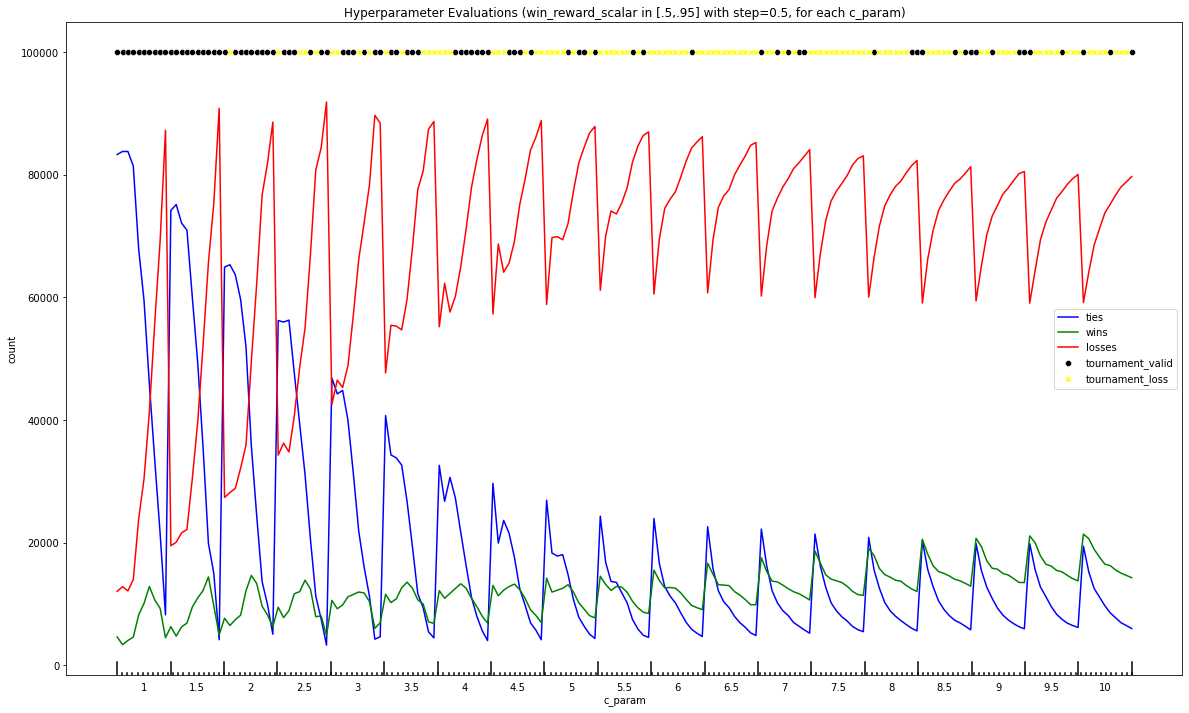

In [218]:
space = np.linspace(0,len(tot_results)-1,len(tot_results))
good_models = [space[i] for i in range(len(space)) if model_validation[i]]
bad_models = [space[i] for i in range(len(space)) if not model_validation[i]]

fig, ax = plt.subplots(figsize=(20,12))
sns.lineplot(x=np.linspace(0,len(tot_results)-1,len(tot_results)), y=[r[0] for r in tot_results], color='blue', label='ties',ax=ax)
sns.lineplot(x=np.linspace(0,len(tot_results)-1,len(tot_results)), y=[r[1] for r in tot_results], color='green', label='wins',ax=ax)
sns.lineplot(x=np.linspace(0,len(tot_results)-1,len(tot_results)), y=[r[-1] for r in tot_results], color='red', label='losses',ax=ax)
sns.scatterplot(x=good_models, y=[100000]*len(good_models), color='black', marker='o', label='tournament_valid',ax=ax)
sns.scatterplot(x=bad_models, y=[100000]*len(bad_models), color='yellow', marker = 'X', label='tournament_loss', ax=ax)
for x in np.linspace(0,len(tot_results)-1,20):
    ax.axvline(x=x,ymin=0,ymax=.02, c='black')
for x in np.linspace(0,len(tot_results)-1,200):
    if x%10 == 0: continue
    ax.axvline(x=x,ymin=0,ymax=.002, c='black')
ax.set_xticks(np.linspace(0,len(tot_results)-1,39))
ax.set_xticklabels(['',1,'',1.5,'',2,'',2.5,'',3,'',3.5,'',4,'',4.5,'',5,'',5.5,'',6,'',6.5,'',7,'',7.5,'',8,'',8.5,'',9,'',9.5,'',10,''])
ax.tick_params(bottom=False)
plt.xlabel('c_param')
plt.ylabel('count')
plt.title('Hyperparameter Evaluations (win_reward_scalar in [.5,.95] with step=0.5, for each c_param)')
plt.show()

## Second hyperparam tuning

In [ ]:
roots_new = []
# c_param = 0.1,0.2,...,1
count = 0
for c_param in np.linspace(.1,1,10):
    this_c_param_roots = []
    # win_reward_scalar = 0.25,0.35,...,0.75
    for win_reward_scalar in np.linspace(.25,.75,7):
        count += 1
        print(count,'/ 190')
        root = MonteCarloTreeSearchNode(c_param=c_param, win_reward_scalar=win_reward_scalar, reset_state_tbl=True)
        root.train(n_rollouts = 100000)
        this_c_param_roots.append((root,c_param,win_reward_scalar))
    roots_new.append(this_c_param_roots)

1 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: 0.07 sec             
*DONE* total training time:  0.2719382333336398 min
2 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: 0.01 sec             
*DONE* total training time:  0.3785429683334466 min
3 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: -0.00 sec             
*DONE* total training time:  0.37471529666654535 min
4 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: -0.01 sec             
*DONE* total training time:  0.303851399999985 min
5 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: 0.04 sec             
*DONE* total training time:  0.37112858499992096 min
6 / 190
rollouts_ran: 100000/100000, estimated_time_remaining: 0.00 min, batch_time_diff: -0.08 sec             
*DONE* total training time:  0.3351357083331095 min
7 / 190
roll

In [231]:
roots_new[0][0][1]

0.1

### Tournament

In [225]:
# for each model, play against every other model, going first and going second
def play_move(curr1,curr2):
    if not curr1.children:
        print('not found in move make: ', curr1.c_param, curr1.win_reward_scalar)
        print(curr1.state)
        return curr1, curr2, curr1
    curr1 = curr1.best_child()
    found = False
    for child in curr2.children:
        if child.state == curr1.state:
            curr2 = child
            found = True
            break
    if not found:
        print('not found in move copy: ', curr2.c_param, curr2.win_reward_scalar)
        print(curr2.state)
        print('to:')
        print(curr1.state)
        return curr1, curr2, curr2
    return curr1, curr2, None

def play(m1,m2):
    res = []
    # going first:
    curr1 = m1
    curr2 = m2
    state = ((0,0,0),(0,0,0),(0,0,0))
    curr1_is_curr1 = True
    winner_code = curr1.get_winner_code(curr1.state)
    broke = None
    while winner_code is None:
        curr1, curr2, broke = play_move(curr1,curr2)
        if broke: 
            res.append(1 if (broke == curr2 and curr1_is_curr1) or (broke == curr1 and not curr1_is_curr1) else -1)
            break
        
        # flop player
        curr1, curr2 = curr2, curr1
        curr1_is_curr1 = not curr1_is_curr1

        winner_code = curr1.get_winner_code(curr1.state)
    if not broke:
        res.append(winner_code)

    # going second:
    curr1 = m2
    curr2 = m1
    state = ((0,0,0),(0,0,0),(0,0,0))
    curr1_is_curr1 = False
    winner_code = curr1.get_winner_code(curr1.state)
    broke = None
    while winner_code is None:
        curr1, curr2, broke = play_move(curr1,curr2)
        if broke: 
            res.append(1 if (broke == curr2 and curr1_is_curr1) or (broke == curr1 and not curr1_is_curr1) else -1)
            break

        # flop player
        curr1, curr2 = curr2, curr1
        curr1_is_curr1 = not curr1_is_curr1

        winner_code = curr1.get_winner_code(curr1.state)
    if not broke:
        res.append(winner_code)

    return res
        

just_roots = np.array(roots_new).flatten()
just_roots = [just_roots[i*3] for i in range(int(just_roots.shape[0]/3))]

tournament_results = [play(m1,m2) for m1 in just_roots for m2 in just_roots]
tournament_results
flat = list(np.array(tournament_results).flatten())
model_validation = [not(-1 not in flat[140*i:140*(i+1)]) for i in range(int(len(flat)/140))]

print(len(model_validation))
model_validation[:5]

not found in move make:  0.1 0.3333333333333333
((0, 0, 0), (0, 0, 0), (0, 1, 0))
not found in move make:  0.1 0.25
((-1, 0, 0), (0, 0, 0), (1, 1, 0))
not found in move make:  0.1 0.41666666666666663
((0, 0, 0), (0, 0, 0), (0, 1, 0))
not found in move make:  0.1 0.41666666666666663
((1, 0, 0), (0, 0, 0), (-1, 0, 0))
not found in move make:  0.1 0.5
((0, 0, 0), (0, 0, 0), (0, 1, 0))
not found in move make:  0.1 0.5
((1, 0, 0), (0, 0, 0), (-1, 0, 0))
not found in move make:  0.1 0.5833333333333333
((0, 0, 0), (0, 0, 0), (0, 1, 0))
not found in move make:  0.1 0.25
((-1, 1, 0), (0, 1, 0), (0, 0, 0))
not found in move copy:  0.1 0.25
((1, 0, 0), (0, 0, 0), (-1, 1, 0))
to:
((1, -1, 0), (0, 0, 0), (-1, 1, 0))
not found in move copy:  0.1 0.25
((-1, 0, 0), (0, 1, 0), (0, 0, 0))
to:
((-1, 0, 0), (0, 1, 0), (0, 1, 0))
not found in move make:  0.1 0.25
((0, 0, 0), (0, -1, 0), (0, 1, 0))
not found in move make:  0.1 0.25
((-1, 0, 1), (0, 0, 0), (1, 0, 0))
not found in move copy:  0.2 0.25
((-1, 0

[True, True, True, True, True]

### Visualize hyperparameter distributions

In [235]:
tot_results = []
for i in range(len(roots_new)):
    for j in range(len(roots_new[0])):
        results = roots[i][j][0].results.copy()
        results[-1] -= results[0]
        tot_results.append(results)

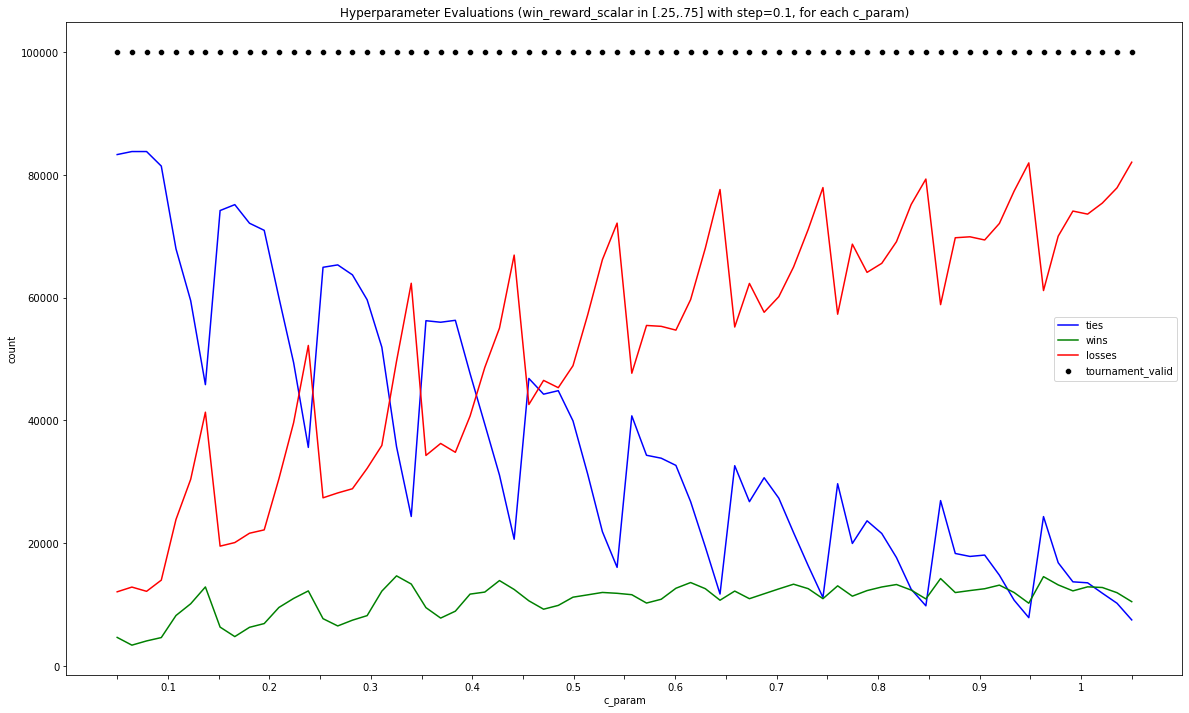

In [236]:
space = np.linspace(0,len(tot_results)-1,len(tot_results))
good_models = [space[i] for i in range(len(space)) if model_validation[i]]
bad_models = [space[i] for i in range(len(space)) if not model_validation[i]]

fig, ax = plt.subplots(figsize=(20,12))
sns.lineplot(x=np.linspace(0,len(tot_results)-1,len(tot_results)), y=[r[0] for r in tot_results], color='blue', label='ties',ax=ax)
sns.lineplot(x=np.linspace(0,len(tot_results)-1,len(tot_results)), y=[r[1] for r in tot_results], color='green', label='wins',ax=ax)
sns.lineplot(x=np.linspace(0,len(tot_results)-1,len(tot_results)), y=[r[-1] for r in tot_results], color='red', label='losses',ax=ax)
sns.scatterplot(x=good_models, y=[100000]*len(good_models), color='black', marker='o', label='tournament_valid',ax=ax)
sns.scatterplot(x=bad_models, y=[100000]*len(bad_models), color='yellow', marker = 'X', label='tournament_loss', ax=ax)
# for x in np.linspace(0,len(tot_results)-1,20):
#     ax.axvline(x=x,ymin=0,ymax=.02, c='black')
# for x in np.linspace(0,len(tot_results)-1,200):
#     if x%10 == 0: continue
#     ax.axvline(x=x,ymin=0,ymax=.002, c='black')
ax.set_xticks(np.linspace(0,len(tot_results)-1,21))
ax.set_xticklabels(['',.1,'',.2,'',.3,'',.4,'',.5,'',.6,'',.7,'',.8,'',.9,'',1,''])
# ax.tick_params(bottom=False)
plt.xlabel('c_param')
plt.ylabel('count')
plt.title('Hyperparameter Evaluations (win_reward_scalar in [.25,.75] with step=0.1, for each c_param)')
plt.show()

# Test Game

In [ ]:
# set iterable node to root
curr = root
# print size of lookup table
print('state_tbl size:', len(MonteCarloTreeSearchNode.state_tbl))
while curr.children:
    #print this node's state
    for i in range(3):
        print(curr.state[i])

    #display child stats for this node
    df = pd.DataFrame(data=[[child.player,len(child.parents),curr.n_visits,child.n_visits,child.results[1],child.results[0],child.results[-1],child.q()/child.n_visits,child.explore_exploit_val(curr)] for child in curr.children],
                      columns=['player','num_parents','parent_n','child_n','w','t','l','q/n','ee_val']).style.highlight_max(color = 'green', axis = 0)
    display(df)
    # set node to the most visited child
    curr = curr.best_child()
# print final game state
for i in range(3):
    print(curr.state[i])

state_tbl size: 3375
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)


,player,num_parents,parent_n,child_n,w,t,l,q/n,ee_val
0,1,1,10000000,5051975,92522,4902404,4959453,0.256334,0.258120
1,1,1,10000000,4578495,14964,4544762,4563531,0.250609,0.252486
2,1,1,10000000,5175163,121889,5027830,5053274,0.260547,0.262312
3,1,1,10000000,4689661,230059,4380209,4459602,0.270296,0.272150
4,1,1,10000000,5303682,408057,4801677,4895625,0.284041,0.285784
5,1,1,10000000,5674334,201980,5415147,5472354,0.265277,0.266963
6,1,1,10000000,4895344,359236,4482806,4536108,0.283970,0.285784
7,1,1,10000000,3998188,910,3984070,3997278,0.249288,0.251296
8,1,1,10000000,2574748,78369,2450179,2496379,0.260733,0.263235


(0, 0, 0)
(0, 0, 1)
(0, 0, 0)


,player,num_parents,parent_n,child_n,w,t,l,q/n,ee_val
0,-1,1,5674334,142080,45850,224,96230,0.242423,0.252885
1,-1,1,5674334,2087776,171,2085505,2087605,0.249789,0.252519
2,-1,1,5674334,3336231,624,3329943,3335607,0.249669,0.251828
3,-1,1,5674334,4868126,54966,4790618,4813160,0.254488,0.256275
4,-1,1,5674334,3070547,1102,3062594,3069445,0.249622,0.251872
5,-1,1,5674334,2593127,56583,2349138,2536544,0.242843,0.245292
6,-1,1,5674334,1280194,9694,1244437,1270500,0.248696,0.252182
7,-1,1,5674334,4259751,9673,4168639,4250078,0.246356,0.248267


(0, 0, 0)
(-1, 0, 1)
(0, 0, 0)


,player,num_parents,parent_n,child_n,w,t,l,q/n,ee_val
0,1,2,4868126,5,2,2,3,0.400000,2.154891
1,1,2,4868126,2,0,0,2,0.000000,2.774727
2,1,2,4868126,4,2,1,2,0.437500,2.399528
3,1,2,4868126,2430117,23165,2351445,2406952,0.249056,0.251573
4,1,2,4868126,2551758,1715,2549764,2550043,0.250309,0.252765
5,1,1,4868126,8,7,0,1,0.656250,2.043613
6,1,1,4868126,4,2,1,2,0.437500,2.399528


(0, 0, 0)
(-1, 0, 1)
(1, 0, 0)


,player,num_parents,parent_n,child_n,w,t,l,q/n,ee_val
0,-1,2,2551758,1591,267,163,1324,0.151477,0.247770
1,-1,2,2551758,949622,0,949104,949622,0.249864,0.253805
2,-1,2,2551758,1604954,0,1604442,1604954,0.249920,0.252952
3,-1,2,2551758,2507967,9,2507947,2507958,0.250001,0.252426
4,-1,1,2551758,2739,2,1610,2737,0.147499,0.220889
5,-1,2,2551758,5620,2,5512,5618,0.245463,0.296697


(0, 0, 0)
(-1, -1, 1)
(1, 0, 0)


,player,num_parents,parent_n,child_n,w,t,l,q/n,ee_val
0,1,3,2507967,2507948,5,2507943,2507943,0.250001,0.252425
1,1,3,2507967,3,0,0,3,0.000000,2.216227
2,1,3,2507967,945139,4,945129,945135,0.250001,0.253949


(1, 0, 0)
(-1, -1, 1)
(1, 0, 0)


,player,num_parents,parent_n,child_n,w,t,l,q/n,ee_val
0,-1,3,2507948,945132,0,945128,945132,0.249999,0.253947
1,-1,3,2507948,1562810,0,1562809,1562810,0.250000,0.253070
2,-1,2,2507948,3,0,3,3,0.250000,2.466226


(1, 0, -1)
(-1, -1, 1)
(1, 0, 0)


,player,num_parents,parent_n,child_n,w,t,l,q/n,ee_val
0,1,3,1562810,908976,0,908976,908976,0.250000,0.253961
1,1,3,1562810,908974,0,908974,908974,0.250000,0.253961
2,1,4,1562810,653833,0,653833,653833,0.250000,0.254670


(1, 1, -1)
(-1, -1, 1)
(1, 0, 0)


,player,num_parents,parent_n,child_n,w,t,l,q/n,ee_val
0,-1,3,908976,3,0,3,3,0.250000,2.388541
1,-1,2,908976,908970,0,908970,908970,0.250000,0.253885


(1, 1, -1)
(-1, -1, 1)
(1, 0, -1)


,player,num_parents,parent_n,child_n,w,t,l,q/n,ee_val
0,1,3,908970,945126,0,945126,945126,0.250000,0.253810


(1, 1, -1)
(-1, -1, 1)
(1, 1, -1)


# Count largest state_tbl size = 5477

In [142]:
q = [MonteCarloTreeSearchNode(reset_state_tbl=True)]
while q:
    curr = q.pop(0)
    if curr.is_game_over_node: continue
    while not curr.is_fully_expanded():
        curr.expand()
    for child in curr.children:
        q.append(child)
len(MonteCarloTreeSearchNode.state_tbl)

549946